# Spam URL Detection 
## using Decision Tree algorithm.

In [148]:
from __future__ import division
import os
import sys
import re
import matplotlib
import pandas as pd
import numpy as np
from os.path import splitext
import ipaddress as ip
import tldextract
import whois
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
from urllib.parse import urlparse

In [149]:
df = pd.read_csv("./dataset.csv")
df = df.sample(frac=1).reset_index(drop=True)
print("Sample size: ", len(df))
df.head()

Sample size:  7030


,URL,Lable
0,http://paradiseroasters.com/,0
1,http://snip.ly/8mrya,1
2,http://www.nudistflirting.com/,0
3,http://www.johnabate.com/,0
4,http://casadelaplaya.net/comadnndd/harsh-tag.g...,1


In [150]:
#2016's top most suspicious TLD and words
Suspicious_TLD=['zip','cricket','link','work','party','gq','kim','country','science','tk']
Suspicious_Domain=['luckytime.co.kr','mattfoll.eu.interia.pl','trafficholder.com','dl.baixaki.com.br','bembed.redtube.comr','tags.expo9.exponential.com','deepspacer.com','funad.co.kr','trafficconverter.biz']
#trend micro's top malicious domains 

## Feature extraction from URLs

In [151]:
# Method to count number of dots
def countdots(url):  
    return url.count('.')

In [152]:
# Method to count number of delimeters
def countdelim(url):
    count = 0
    delim=[';','_','?','=','&']
    for each in url:
        if each in delim:
            count = count + 1
    
    return count

In [153]:
# Is IP addr present as th hostname, let's validate

import ipaddress as ip #works only in python 3

def isip(uri):
    try:
        if ip.ip_address(uri):
            return 1
    except:
        return 0

In [154]:
#method to check the presence of hyphens

def isPresentHyphen(url):
    return url.count('-')
        

In [155]:
#method to check the presence of @

def isPresentAt(url):
    return url.count('@')

In [156]:
def isPresentDSlash(url):
    return url.count('//')

In [157]:
def countSubDir(url):
    return url.count('/')

In [158]:
def get_ext(url):
    """Return the filename extension from url, or ''."""
    
    root, ext = splitext(url)
    return ext

In [159]:
def countSubDomain(subdomain):
    if not subdomain:
        return 0
    else:
        return len(subdomain.split('.'))

In [160]:
def countQueries(query):
    if not query:
        return 0
    else:
        return len(query.split('&'))

In [161]:
featureSet = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

In [162]:
from urllib.parse import urlparse
import tldextract
def getFeatures(url, label): 
    result = []
    url = str(url)
    
    #add the url to feature set
    result.append(url)
    
    #parse the URL and extract the domain information
    path = urlparse(url)
    ext = tldextract.extract(url)
    
    #counting number of dots in subdomain    
    result.append(countdots(ext.subdomain))
    
    #checking hyphen in domain   
    result.append(isPresentHyphen(path.netloc))
    
    #length of URL    
    result.append(len(url))
    
    #checking @ in the url    
    result.append(isPresentAt(path.netloc))
    
    #checking presence of double slash    
    result.append(isPresentDSlash(path.path))
    
    #Count number of subdir    
    result.append(countSubDir(path.path))
    
    #number of sub domain    
    result.append(countSubDomain(ext.subdomain))
    
    #length of domain name    
    result.append(len(path.netloc))
    
    #count number of queries    
    result.append(len(path.query))
    
    #Adding domain information
    
    #if IP address is being used as a URL     
    result.append(isip(ext.domain))
    
    #presence of Suspicious_TLD
    result.append(1 if ext.suffix in Suspicious_TLD else 0)
    
    #presence of suspicious domain
    result.append(1 if '.'.join(ext[1:]) in Suspicious_Domain else 0 )
    
    #result.append(get_ext(path.path))
    result.append(str(label))
    return result
                  
    #Yay! finally done!  




In [163]:
for i in range(len(df)):
    features = getFeatures(df["URL"].loc[i], df["Lable"].loc[i])    
    featureSet.loc[i] = features      

In [164]:
featureSet.head()

,url,no of dots,presence of hyphen,len of url,presence of at,presence of double slash,no of subdir,no of subdomain,len of domain,no of queries,is IP,presence of Suspicious_TLD,presence of suspicious domain,label
0,http://paradiseroasters.com/,0,0,28,0,0,1,0,20,0,0,0,0,0
1,http://snip.ly/8mrya,0,0,20,0,0,1,0,7,0,0,0,0,1
2,http://www.nudistflirting.com/,0,0,30,0,0,1,1,22,0,0,0,0,0
3,http://www.johnabate.com/,0,0,25,0,0,1,1,17,0,0,0,0,0
4,http://casadelaplaya.net/comadnndd/harsh-tag.g...,0,0,106,0,0,4,0,17,0,0,0,0,1


Visualization of data based on features

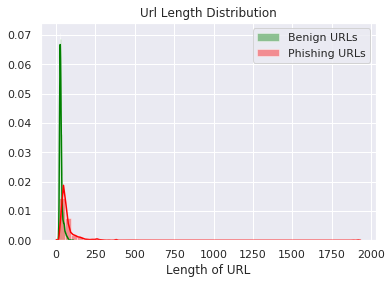

In [165]:
sns.set(style="darkgrid")
sns.distplot(featureSet[featureSet['label']=='0']['len of url'],color='green',label='Benign URLs')
sns.distplot(featureSet[featureSet['label']=='1']['len of url'],color='red',label='Phishing URLs')
plt.title('Url Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of URL')

plt.show()

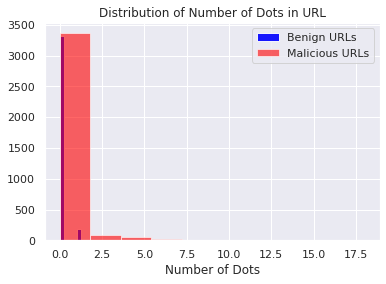

In [166]:
x=featureSet[featureSet['label']=='0']['no of dots']
y=featureSet[featureSet['label']=='1']['no of dots']
plt.hist(x,bins=8, alpha=0.9, label='Benign URLs',color='blue')
#sns.distplot(x,bins=8,color='blue',label='Benign URLs')
plt.hist(y,bins=10, alpha=0.6, label='Malicious URLs',color='red')
#sns.distplot(y,bins=8,color='red',label='Malicious URLs')
plt.legend(loc='upper right')
plt.xlabel('Number of Dots')
plt.title('Distribution of Number of Dots in URL')
plt.show()

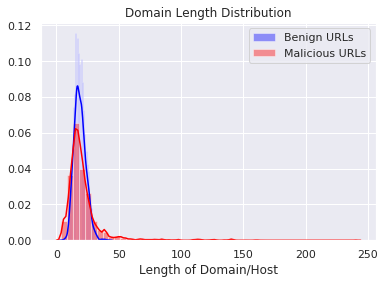

In [167]:
sns.set(style="darkgrid")
sns.distplot(featureSet[featureSet['label']=='0']['len of domain'],color='blue',label='Benign URLs')
sns.distplot(featureSet[featureSet['label']=='1']['len of domain'],color='red',label='Malicious URLs')
plt.title('Domain Length Distribution')
plt.legend(loc='upper right')
plt.xlabel('Length of Domain/Host')
plt.show()

In [168]:
import sklearn.ensemble as ek
from sklearn import model_selection, tree, linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn import svm
from sklearn.linear_model import LogisticRegression


In [169]:
featureSet.groupby(featureSet['label']).size()

label
0    3494
1    3536
dtype: int64

In [170]:
X = featureSet.drop(['url','label'],axis=1).values
y = featureSet['label'].values

## Learning

In [171]:
model = {"DecisionTree":tree.DecisionTreeClassifier(max_depth=10)}

# Other models :
# model = { "DecisionTree":tree.DecisionTreeClassifier(max_depth=10),
#          "RandomForest":ek.RandomForestClassifier(n_estimators=50),
#          "Adaboost":ek.AdaBoostClassifier(n_estimators=50),
#          "GradientBoosting":ek.GradientBoostingClassifier(n_estimators=50),
#          "GNB":GaussianNB(),
#          "LogisticRegression":LogisticRegression()   
# }

In [172]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y ,test_size=0.2)

In [173]:
results = {}
for algo in model:
    clf = model[algo]
    clf.fit(X_train,y_train)
    score = clf.score(X_test,y_test)
    print ("%s : %s " %(algo, score))
    results[algo] = score

DecisionTree : 0.903271692745377 


In [174]:
winner = max(results, key=results.get)
print(winner)

DecisionTree


In [175]:
clf = model[winner]
res = clf.predict(X)
mt = confusion_matrix(y, res)
print("False positive rate : %f %%" % ((mt[0][1] / float(sum(mt[0])))*100))
print('False negative rate : %f %%' % ( (mt[1][0] / float(sum(mt[1]))*100)))

False positive rate : 7.985117 %
False negative rate : 6.250000 %


### Testing

Urls:
- trafficconverter.biz:80/4vir/antispyware/loadadv.exe | 1
- am10.ru:80/code.php | 1
- zbavit.live/data/login.php | 1
- iiti.ac.in | 0
- services.runescape.com-aje.top | 1

Let's test' some of the malicious URL's listed in Trend Micro's website. http://apac.trendmicro.com/apac/security-intelligence/current-threat-activity/malicious-top-ten/

In [176]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('trafficconverter.biz:80/4vir/antispyware/loadadv.exe', '1')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['0']


In [177]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('am10.ru:80/code.php', '1')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['1']


In [178]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('zbavit.live/data/login.php', '1')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['0']


In [179]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('iiti.ac.in', '0')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['1']


In [180]:
result = pd.DataFrame(columns=('url','no of dots','presence of hyphen','len of url','presence of at',\
'presence of double slash','no of subdir','no of subdomain','len of domain','no of queries','is IP','presence of Suspicious_TLD',\
'presence of suspicious domain','label'))

results = getFeatures('services.runescape.com-aje.top', '1')
result.loc[0] = results
result = result.drop(['url','label'],axis=1).values
print(clf.predict(result))

['1']
